In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
!unzip /content/drive/MyDrive/ColabNotebooks/cultimax/dataset.zip

Archive:  /content/drive/MyDrive/ColabNotebooks/cultimax/dataset.zip
replace dataset/train/Cherry___Powdery_mildew/00b7df55-c789-43d6-a02e-a579ac9d07e6___FREC_Pwd.M 4748.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset/train/Cherry___Powdery_mildew/00b7df55-c789-43d6-a02e-a579ac9d07e6___FREC_Pwd.M 4748.JPG  
  inflating: dataset/train/Cherry___Powdery_mildew/00d12ac0-a293-47e0-a4c6-a80f37204c39___FREC_Pwd.M 4812.JPG  
  inflating: dataset/train/Cherry___Powdery_mildew/00d12ac0-a293-47e0-a4c6-a80f37204c39___FREC_Pwd.M 4812_flipLR.JPG  
  inflating: dataset/train/Cherry___Powdery_mildew/00e0a4ab-ecbd-4560-a71c-b19d86bb087c___FREC_Pwd.M 4917_flipLR.JPG  
  inflating: dataset/train/Cherry___Powdery_mildew/00f8611c-0f2c-4f24-8241-d1748c8bb48f___FREC_Pwd.M 0479.JPG  
  inflating: dataset/train/Cherry___Powdery_mildew/00f8611c-0f2c-4f24-8241-d1748c8bb48f___FREC_Pwd.M 0479_flipLR.JPG  
  inflating: dataset/train/Cherry___Powdery_mildew/0a283423-3a6d-43a4-92e5-267c8153ca45___FR

In [3]:
!pip install -r /content/drive/MyDrive/ColabNotebooks/cultimax/requirements.txt

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyfcm: filename=pyfcm-1.5.4-py3-none-any.whl size=15018 sha256=17777857d79c58e3f19b40a86032047a76cb3d9ffa727d6a5bf555c7b58f35b5
  Stored in directory: /root/.cache/pip/wheels/bf/2b/e3/aef10c2f5810d3aa49479bba085296978066fdd46eefe2e335
Successfully built pyfcm
  Attempting uninstall: flask
    Found existing installation: Flask 2.2.5
    Uninstalling Flask-2.2.5:
      Successfully uninstalled Flask-2.2.5


In [21]:
from PIL import Image
import torch
import torchvision
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import pickle

In [22]:
class Dataset():
    def __init__(self):
        self.labels,self.images = self.load_data()

    # To load images and labels for dataloader
    def load_data(self):
        labels={}
        images = {}
        count = 0
        # setting resize dimensions
        resize = transforms.Compose([transforms.Resize((256,256))])
        main_dir = os.listdir(os.path.join("dataset","train"))
        reference = {}
        # iterating through categories
        for i,dir in enumerate(main_dir):
            reference[dir]=i
            images_list = os.listdir(os.path.join("dataset","train",dir))
            local_cnt = 0
            # iterating through images in a category
            for img in images_list:
                # 500 images from each category
                if local_cnt<500:
                    labels[count] = i
                    img_path = os.path.join("dataset","train",dir,img)
                    image = Image.open(img_path)
                    image = ToTensor()(image)
                    images[count] = resize(image)
                    count+=1
                    local_cnt+=1
                else:
                    break

        print(reference)
        return labels,images

    def __len__(self):
        return len(self.labels)


    # To return x,y values in each iteration over dataloader as batches.
    def __getitem__(self, idx):
        return (
            self.images[idx],
            self.labels[idx],
        )

In [23]:
# Inherit from Dataset class
class ValDataset(Dataset):

    def load_data(self):
          labels={}
          images = {}
          count = 0
          resize = transforms.Compose([transforms.Resize((256,256))])
          main_dir = os.listdir(os.path.join("dataset","valid"))
          for i,dir in enumerate(main_dir):
              print(i,dir)
              images_list = os.listdir(os.path.join("dataset","valid",dir))
              local_cnt = 0
              for img in images_list:
                  if(local_cnt<100):
                      labels[count] = i
                      img_path = os.path.join("dataset","valid",dir,img)
                      image = Image.open(img_path)
                      image = ToTensor()(image)
                      images[count] = resize(image)
                      count+=1
                      local_cnt+=1
                  else:
                      break

          return labels,images


In [24]:
# Model Architecture
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        # CNNs for rgb images
        self.conv1= nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5)
        self.conv2= nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5)
        self.conv3= nn.Conv2d(in_channels=12,out_channels=24,kernel_size=5)
        self.conv4= nn.Conv2d(in_channels=24,out_channels=48,kernel_size=5)

        # Connecting CNN outputs with Fully Connected layers
        self.fc1 = nn.Linear(in_features=48*12*12,out_features=240)
        self.fc2 = nn.Linear(in_features=240,out_features=120)
        self.out = nn.Linear(in_features=120,out_features=17)


    def forward(self,t):
        t = t

        t=self.conv1(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)


        t=self.conv2(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)

        t=self.conv3(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)

        t=self.conv4(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)

        t=t.reshape(-1,48*12*12)
        t=self.fc1(t)
        t=F.relu(t)


        t=self.fc2(t)
        t=F.relu(t)

        t=self.out(t)


        return t

In [38]:
model = Network()

In [26]:
dataset = Dataset()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


{'Cherry___Powdery_mildew': 0, 'Cherry___healthy': 1, 'Pepper___Bacterial_spot': 2, 'Potato___healthy': 3, 'Tomato___Septoria_leaf_spot': 4, 'Tomato___Bacterial_spot': 5, 'Tomato___Late_blight': 6, 'Tomato___Target_Spot': 7, 'Pepper___healthy': 8, 'Potato___Early_blight': 9, 'Tomato___Early_blight': 10, 'Tomato___Leaf_Mold': 11, 'Potato___Late_blight': 12, 'Tomato___Tomato_mosaic_virus': 13, 'Tomato___Spider_mites Two-spotted_spider_mite': 14, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 15, 'Tomato___healthy': 16}


In [28]:
valdataset = ValDataset()

0 Cherry___Powdery_mildew
1 Cherry___healthy
2 Pepper___Bacterial_spot
3 Potato___healthy
4 Tomato___Septoria_leaf_spot
5 Tomato___Bacterial_spot
6 Tomato___Late_blight
7 Tomato___Target_Spot
8 Pepper___healthy
9 Potato___Early_blight
10 Tomato___Early_blight
11 Tomato___Leaf_Mold
12 Potato___Late_blight
13 Tomato___Tomato_mosaic_virus
14 Tomato___Spider_mites Two-spotted_spider_mite
15 Tomato___Tomato_Yellow_Leaf_Curl_Virus
16 Tomato___healthy


In [29]:
# Function to return number of correct predictions in a batch
def get_num_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [39]:
def train(dataset,valdataset, model):
    model.train()

    # dataloader in pytorch to load validation and train dataset
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64,shuffle=True)
    valdataloader = torch.utils.data.DataLoader(valdataset, batch_size=32,shuffle=True)

    # Defining the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_of_epochs = 18
    epochs = []
    losses = []
    for epoch in range(num_of_epochs):
        cnt = 0
        total =0
        tot_loss = 0
        tot_correct = 0
        for batch, (x, y) in enumerate(dataloader):
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            y_pred = model(x)
            # Compute loss (here CrossEntropyLoss)
            loss = F.cross_entropy(y_pred,y)
            loss.backward()
            optimizer.step()

        for batch, (x, y) in enumerate(valdataloader):
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            with torch.no_grad():
                y_pred = model(x)
                # Compute loss (here CrossEntropyLoss)
                loss = F.cross_entropy(y_pred,y)
            total += y.size(0)
            tot_loss+=loss.item()
            tot_correct +=get_num_correct(y_pred,y)
            #"Acc", (100 * tot_correct / total)
        epochs.append(epoch)
        losses.append(tot_loss)
        print("Epoch",epoch,"total_correct",tot_correct,"loss:",tot_loss)
        torch.save(model.state_dict(), "model002_ep"+str(epoch+1)+".pth")

    # Plot a Validation Loss vs Epochs graph
    plt.plot(epochs, losses, color='green', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=8)
    plt.xlabel('epochs ---->',color='m',fontsize='xx-large' )
    plt.ylabel('loss ------>',color='m',fontsize='xx-large')
    axes = plt.gca()        # 'gca' - get current axes
    axes.set_facecolor('c') #'c' - cyan
    axes.tick_params(axis='y', which='both', colors='tomato')
    axes.tick_params(axis='x', which='both', colors='#20ff14')
    plt.title("Val Loss vs Epoch",color='m',fontsize='xx-large')

Epoch 0 total_correct 10 loss: 16.998716354370117
Epoch 1 total_correct 10 loss: 16.695972681045532
Epoch 2 total_correct 23 loss: 15.424164295196533
Epoch 3 total_correct 22 loss: 15.888544797897339
Epoch 4 total_correct 29 loss: 14.464121103286743
Epoch 5 total_correct 29 loss: 14.294782638549805
Epoch 6 total_correct 31 loss: 13.456650733947754
Epoch 7 total_correct 31 loss: 14.74270224571228
Epoch 8 total_correct 40 loss: 13.422596335411072
Epoch 9 total_correct 37 loss: 14.973588705062866
Epoch 10 total_correct 44 loss: 12.557053685188293
Epoch 11 total_correct 40 loss: 14.714248180389404
Epoch 12 total_correct 52 loss: 12.575685143470764
Epoch 13 total_correct 44 loss: 13.446204423904419
Epoch 14 total_correct 48 loss: 13.180729627609253
Epoch 15 total_correct 52 loss: 12.564108967781067
Epoch 16 total_correct 58 loss: 13.40021824836731
Epoch 17 total_correct 63 loss: 12.594048500061035


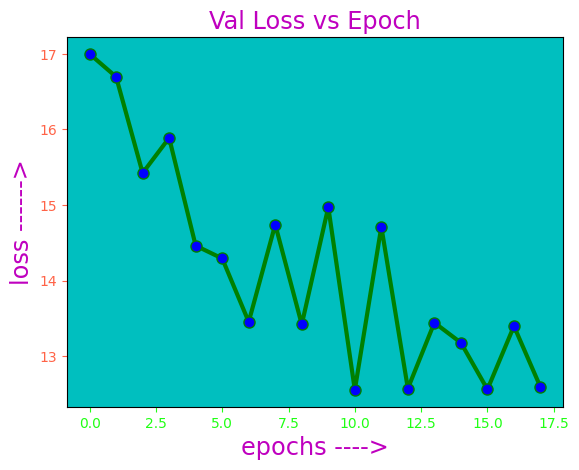

In [40]:
train(dataset,valdataset, model)

In [41]:
# Saving labels to label value as a json
main_dir = os.listdir(os.path.join('/content/dataset/train'))
reference = {}
for i,dir in enumerate(main_dir):
    reference[dir]=i
with open('labels.json', 'wb') as iw:
    pickle.dump(reference, iw)

print(reference)

{'Cherry___Powdery_mildew': 0, 'Cherry___healthy': 1, 'Pepper___Bacterial_spot': 2, 'Potato___healthy': 3, 'Tomato___Septoria_leaf_spot': 4, 'Tomato___Bacterial_spot': 5, 'Tomato___Late_blight': 6, 'Tomato___Target_Spot': 7, 'Pepper___healthy': 8, 'Potato___Early_blight': 9, 'Tomato___Early_blight': 10, 'Tomato___Leaf_Mold': 11, 'Potato___Late_blight': 12, 'Tomato___Tomato_mosaic_virus': 13, 'Tomato___Spider_mites Two-spotted_spider_mite': 14, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 15, 'Tomato___healthy': 16}


In [42]:
#Save the trained model
torch.save(model.state_dict(), "/content/drive/MyDrive/ColabNotebooks/cultimax/model.pth")

In [43]:
# prediction function to test
def predict(img_path):
    print("Predicting")
    image = Image.open(img_path)
    image = ToTensor()(image)
    resize = transforms.Compose([transforms.Resize((256,256))])
    y_result = model(resize(image).unsqueeze(0))
    result_idx = y_result.argmax(dim=1)
    for key,value in reference.items():
        if(value==result_idx):
            print(key)
            break




In [51]:
predict('/content/drive/MyDrive/ColabNotebooks/cultimax/test/TomatoYellowCurlVirus1.JPG')

Predicting
Tomato___Tomato_Yellow_Leaf_Curl_Virus
